# Spam classification

Spam classification is a classic application of machine learning.
In this notebook, I implement a spam classifier and compare feature-extraction methods.

Data. We use the Apache SpamAssassin public corpus: easy_ham_20030228 and spam_20050311 (see: https://spamassassin.apache.org/old/publiccorpus/

In [ ]:
import os
import pathlib


# File existence validation
input_dir = "input"
ham_file_name = r"20030228_easy_ham_2\easy_ham_2"
ham_dir_path = os.fspath(ham_file_name)
spam_file_name = r"20030228_spam_2\spam_2"
spam_dir_path = os.fspath(spam_file_name)

if os.path.exists(input_dir) and os.path.isdir(input_dir):
    print(f"Directory '{input_dir}' exists")
    spam_path = os.path.join(input_dir, spam_dir_path)
    ham_path = os.path.join(input_dir, ham_dir_path)
    if (
        os.path.exists(spam_path)
        and os.path.isdir(spam_path)
        and os.path.exists(ham_path)
        and os.path.isdir(ham_path)
    ):
        if not os.listdir(spam_path):
            raise FileNotFoundError(
                f"The input files were not found in {spam_path}, please extract the files from the compressed archive folder or download the correct files"
            )
        if not os.listdir(ham_path):
            raise FileNotFoundError(
                f"The input files were not found in {ham_path}, please extract the files from the compressed archive folder or download the correct files"
            )

        print("Input files exist")
    else:
        raise FileNotFoundError(
            "The input files were not found in the './input' directory, please download the correct"
            "files fromt he spamassassin website and try again"
        )

else:
    raise FileNotFoundError(
        f"Directory '{input_dir}' does not exist in the current path, please download the missing folder from the repository"
    )


Directory 'input' exists
Input files exist


We will include headers and body text. For features we will try:

Count and TF-IDF  via CountVectorizer / TfidfVectorizer.

Alternative: HashingVectorizer (feature hashing) avoids building a vocabulary and is memory-constant. Useful for online or distributed systems, at the cost of hash collisions. Our dataset (~2.5k messages) is small enough to use a learned vocabulary comfortably.

The key strategies used for bag of words n-gram features are:
- Tokenization: Splits text into tokens, may map to an integer id internally.
- Counting: Compute token (or n-gram) counts per document.
- Normalizing and Weighting: Downweight counts for globally frequent terms
And dependign on the use case:

- Filtering: Filter out words such as 'him', 'I' etc., words that occur frequently but do not add any meaningful information for certain tasks. These words are known as stop_words. Take our task for example, the amount of 'I's in an email, liekly has no meaningful way of telling us if the email is spam or ham as it is a word that can be used frequently in an email, but also can completely ignored in an email. 



N-grams are contiguous sequences of n tokens (word- or character-level).

In Naive Bayes text classification, n-grams are used as independent features. There is no Markov chain;

If we use the markov model, we estimate the likelihoods of an word based on the likelihoods of the ngrams which we caclulate using Bayes chain rule. The assumption here is a word in an n-grams is dependent on the previous n-1 words in the ngram. Such a model is not provided by sklearn and we will not implement it in this notebook

In [ ]:
from sklearn.model_selection import train_test_split
from itertools import permutations
import numpy as np


# Building of test, val and train datasets
rng = np.random.default_rng()
# 1397 spam
spam_file_count = len(os.listdir(spam_path))
print(spam_file_count)
# 1400 ham
ham_file_count = len(os.listdir(ham_path))

spam_index = np.arange(spam_file_count)
ham_index = np.arange(ham_file_count)
print(np.max(spam_index))


spam_train, spam_test = train_test_split(spam_index, train_size=0.8, random_state=42)
ham_train_val, ham_test = train_test_split(ham_index, train_size=0.8, random_state=42)

x_train_val_indices = np.hstack((spam_train, ham_train_val))
# Let spam be our positive class and ham be our negative class
y_train_val = np.hstack(
    (np.ones(shape=len(spam_train)), np.zeros(shape=len(ham_train_val)))
)

x_test_indices = np.hstack((spam_test, ham_test))
# Let spam be our positive class and ham be our negative class
y_test = np.hstack((np.ones(shape=len(spam_test)), np.zeros(shape=len(ham_test))))

shuffled_indices_train = np.arange(len(x_train_val_indices))
rng.shuffle(shuffled_indices_train, axis=0)
x_train_val_indices = x_train_val_indices[shuffled_indices_train]
y_train_val = y_train_val[shuffled_indices_train]
print(np.max(shuffled_indices_train))

shuffled_indices_test = np.arange(len(x_test_indices))
rng.shuffle(shuffled_indices_test, axis=0)
x_test_indices = x_test_indices[shuffled_indices_test]
y_test = y_test[shuffled_indices_test]


1397
1396
2236


TFIDF calculates a term frequency and an inverse document frequency value for each feature. The term frequency is equal to the raw frequency count. The inverse document frequency downweights tokens which are frequent accross documents.

Aditionnaly we can set the term frequency count ot be sublinear, which makes our model assign proportionally lower (log-scaled) counts to the frequency, this means that higher counts count for less than they normally would.

Large n-gram vocabularies produce high-dimensional sparse matrices. Keep them in sparse form; avoid .toarray() / .todense() to prevent memory blowups. Sklearn models support scipy CSA, CSR without this training would be very memory intesive. Try converting the vector into a standard numpy array and you will see that you need aroung 9GB in memory (RAM) to dothis.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# We believe that casing can be a good indicator of ham vs. spam, as is mentioned by Paul Graham
# in his seminal articles, thus we will not casefold or lowercase

cnt_vectorizer = CountVectorizer(
    input="content", lowercase=False, stop_words="english", ngram_range=(2, 2)
)
# TFIDF weights the
tfidf_vectorizer = TfidfVectorizer(
    input="content", lowercase=False, stop_words="english", ngram_range=(2, 2)
)

# Optionally reduce dataset size by factor of 10 to save memory
reduction_factor = 1
x_train_val_indices = x_train_val_indices[::reduction_factor]
y_train_val = y_train_val[::reduction_factor]
x_test_indices = x_test_indices[::reduction_factor]
y_test = y_test[::reduction_factor]

print(f"Reduced train/val set size: {len(x_train_val_indices)}")
print(f"Reduced test set size: {len(x_test_indices)}")

X_train_val = []
X_test = []

# Get the file lists once to avoid repeated calls to os.listdir()
ham_files = os.listdir(ham_path)
spam_files = os.listdir(spam_path)

for i, file_index in enumerate(x_train_val_indices):
    # Ham is negative class (label is 0)
    if y_train_val[i] == 0:
        # Utf-8 has been a webstandard for a long time afaik, so this should work
        # Encoding should be utf-8 no idea why it is throwing errors
        with open(
            os.path.join(ham_path, ham_files[file_index]),
            mode="r",
            encoding="utf-8",
            errors="ignore",
        ) as f:
            text = f.read()
            X_train_val.append(text)
    else:  # Spam is positive class (label is 1)
        with open(
            os.path.join(spam_path, spam_files[file_index]),
            mode="r",
            encoding="utf-8",
            errors="ignore",
        ) as f:
            text = f.read()
            X_train_val.append(text)

for i, file_index in enumerate(x_test_indices):
    # Ham is negative class
    if y_test[i] == 0:
        with open(
            os.path.join(ham_path, ham_files[file_index]),
            mode="r",
            encoding="utf-8",
            errors="ignore",
        ) as f:
            text = f.read()
            X_test.append(text)
    else:
        with open(
            os.path.join(spam_path, spam_files[file_index]),
            mode="r",
            encoding="utf-8",
            errors="ignore",
        ) as f:
            text = f.read()
            X_test.append(text)


# Split raw text into train/val before vectorization
split_idx = int(len(X_train_val) * 0.8)
X_train_raw = X_train_val[:split_idx]
X_val_raw = X_train_val[split_idx:]
y_train = y_train_val[:split_idx]
y_val = y_train_val[split_idx:]

# Vectorize train/val sets
X_train_cnt = cnt_vectorizer.fit_transform(X_train_raw)
X_val_cnt = cnt_vectorizer.transform(X_val_raw)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
X_val_tfidf = tfidf_vectorizer.transform(X_val_raw)

# Vectorize test set
X_test_cnt = cnt_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Free up memory
del X_train_val, X_train_raw, X_val_raw, X_test

# Now X_train_cnt, X_val_cnt, X_test_cnt and their tfidf equivalents are available for training

Reduced train/val set size: 2237
Reduced test set size: 560


We will train 3 models on our vectors.

Multinomial NB is more suited to counts and does not use the markov model. S

We train three models:

MultinomialNB.

BernoulliNB.

Logistic Regression (linear classifier) on count/TF-IDF.

Note: sklearn doesn’t provide a “Bayes + Markov n-gram LM” classifier; implementing class-conditional n-gram language models is outside scope here.

Why TF-IDF can help NB: TF-IDF reduces the impact of repeated tokens that happen to be strong in the training set but don’t generalize, mitigating over-weighting.


In [145]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd


# init models
logr_count_clf = LogisticRegression()
logr_tfidf_clf = LogisticRegression()
nb_count_clf = MultinomialNB()
nb_tfidf_clf = MultinomialNB()
bern_nb_count_clf = BernoulliNB()
bern_nb_tfidf_clf = BernoulliNB()


We evaluate accuracy, precision, recall, plus ROC and PR curves.
Spam is the positive class;

Model: LogisticRegression, Features: CountVectorizer
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
Threshold for precision=0.95: 0.00524407
Recall @ precision=0.95: 1.0000
FPR @ precision=0.95: 0.053751
Model: LogisticRegression, Features: TfidfVectorizer
Accuracy:  0.9648
Precision: 0.9728
Recall:    0.9565
Threshold for precision=0.95: 0.355364
Recall @ precision=0.95: 0.9821
FPR @ precision=0.95: 0.052632
Model: MultinomialNB, Features: CountVectorizer
Accuracy:  0.9748
Precision: 1.0000
Recall:    0.9498
Threshold for precision=0.95: 1.35838e-214
Recall @ precision=0.95: 1.0000
FPR @ precision=0.95: 0.053751
Model: MultinomialNB, Features: TfidfVectorizer
Accuracy:  0.9676
Precision: 0.9976
Recall:    0.9375
Threshold for precision=0.95: 0.0193863
Recall @ precision=0.95: 0.9888
FPR @ precision=0.95: 0.052632
Model: BernoulliNB, Features: CountVectorizer
Accuracy:  0.9748
Precision: 1.0000
Recall:    0.9498
Threshold for precision=0.95: 1.24928e-163
Recall @ precision=0.95:

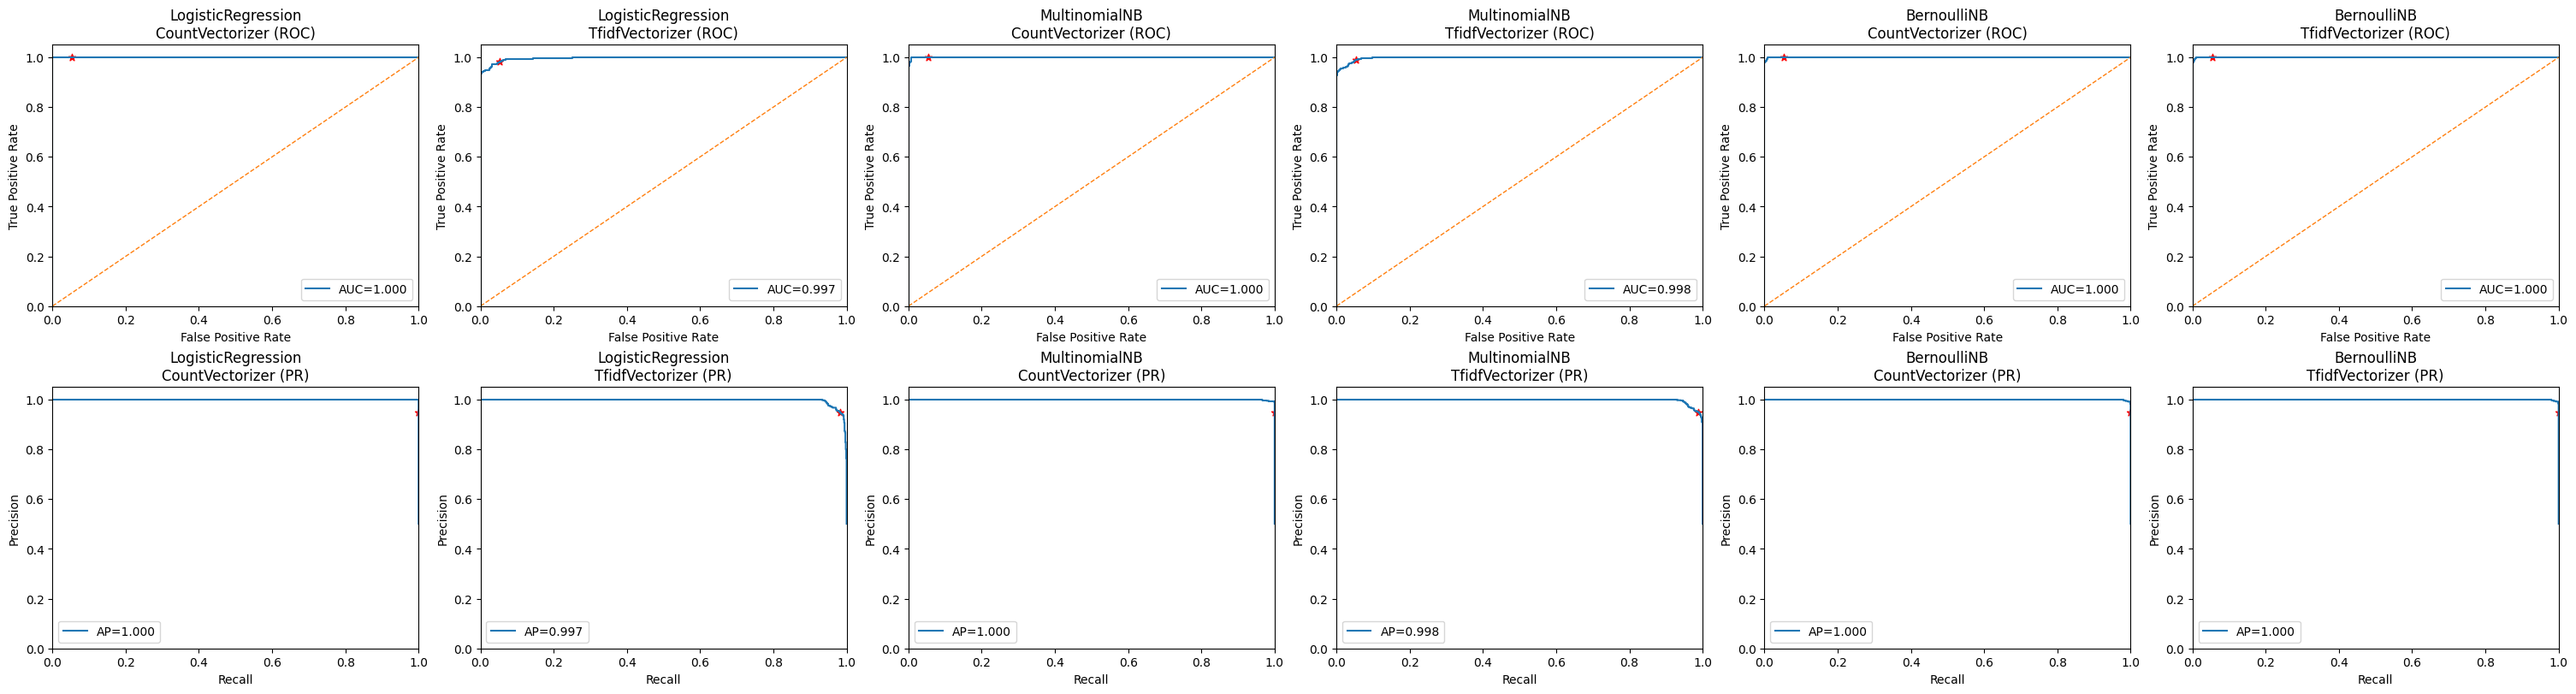

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    roc_curve,
    confusion_matrix,
    precision_recall_curve,
    auc,
    average_precision_score,
    roc_auc_score,
)

import matplotlib.pyplot as plt


def get_scores(model, X):
    """Extract scores (probabilities or decision values) for the positive class"""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        return s if s.ndim == 1 else s[:, list(model.classes_).index(1)]
    raise ValueError(f"{model.__class__.__name__} has no usable score method")


def threshold_for_arbitrary_precision(
    y_true, y_scores, eps=1e-12, precision: float = 0.95
):
    """Return (thr, recall_at_thr). None if precision==1.0 not achievable."""
    prec, rec, thr = precision_recall_curve(y_true, y_scores, pos_label=1)
    # thr maps to prec[1:], rec[1:], first point id the degenerate
    mask = prec[1:] >= precision - eps
    if not np.any(mask):
        return None, None
    cand = np.where(mask)[0]
    #
    best = cand[np.argmax(rec[1:][cand])]
    thr_star = float(thr[best])
    # compute recall at this exact threshold
    y_pred = (y_scores >= thr_star).astype(int)
    rec_at_thr = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    return thr_star, rec_at_thr


def eval_at_threshold(y_true, y_scores, thr):
    """Evaluate classification metrics at a specific threshold"""
    y_pred = (y_scores >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    fpr = fp / (fp + tn) if (fp + tn) else np.nan
    return acc, prec, rec, fpr, np.array([[tn, fp], [fn, tp]])


model_feature_pairs = [
    (logr_count_clf, "CountVectorizer", X_train_cnt),
    (logr_tfidf_clf, "TfidfVectorizer", X_train_tfidf),
    (nb_count_clf, "CountVectorizer", X_train_cnt),
    (nb_tfidf_clf, "TfidfVectorizer", X_train_tfidf),
    (bern_nb_count_clf, "CountVectorizer", X_train_cnt),
    (bern_nb_tfidf_clf, "TfidfVectorizer", X_train_tfidf),
]

for model, feature_type, features in model_feature_pairs:
    model.fit(features, y_train)


n_models = len(model_feature_pairs)
fig, axs = plt.subplots(2, n_models, figsize=(5 * n_models, 8), constrained_layout=True)
thresholds = {}

for i, (model, feature_type, X) in enumerate(model_feature_pairs):
    # Get scores for the positive class using our helper function
    try:
        y_scores = get_scores(model, X)
    except ValueError:
        y_scores = None  # can't make curves

    #  default-threshold metrics ()
    y_pred = model.predict(X)
    acc = accuracy_score(y_train, y_pred)
    prec_def = precision_score(y_train, y_pred, pos_label=1, zero_division=0)
    rec_def = recall_score(y_train, y_pred, pos_label=1, zero_division=0)
    print(
        f"Model: {model.__class__.__name__}, Features: {feature_type}\n"
        f"Accuracy:  {acc:.4f}\n"
        f"Precision: {prec_def:.4f}\n"
        f"Recall:    {rec_def:.4f}"
    )

    ax_roc = axs[0, i]
    ax_pr = axs[1, i]

    if y_scores is None:
        ax_roc.text(0.5, 0.5, "No score output", ha="center", va="center")
        ax_pr.text(0.5, 0.5, "No score output", ha="center", va="center")
        ax_roc.set_title(f"{model.__class__.__name__}\n{feature_type} (ROC)")
        ax_pr.set_title(f"{model.__class__.__name__}\n{feature_type} (PR)")
        continue

    # ROC
    fpr, tpr, thr_roc = roc_curve(y_train, y_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    ax_roc.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    ax_roc.set_xlim(0.0, 1.0)
    ax_roc.set_ylim(0.0, 1.05)
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title(f"{model.__class__.__name__}\n{feature_type} (ROC)")
    ax_roc.legend(loc="lower right")

    # Precision–Recall (Average Precision)
    precision = 0.95
    prec, rec, thr_pr = precision_recall_curve(y_train, y_scores, pos_label=1)
    ap = average_precision_score(y_train, y_scores, pos_label=1)
    ax_pr.plot(rec, prec, label=f"AP={ap:.3f}")
    ax_pr.set_xlim(0.0, 1.0)
    ax_pr.set_ylim(0.0, 1.05)
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title(f"{model.__class__.__name__}\n{feature_type} (PR)")
    ax_pr.legend(loc="lower left")

    # Find threshold for arbitrary precision using our helper function
    thr_star, rec_at_thr = threshold_for_arbitrary_precision(
        y_train, y_scores, precision=precision
    )

    if thr_star is not None:
        thresholds[(model, feature_type)] = thr_star
        # Evaluate metrics at the found threshold
        acc, prec, rec, fpr, _ = eval_at_threshold(y_train, y_scores, thr_star)
        ax_pr.scatter([rec], [prec], marker="*", color="r")
        ax_roc.scatter([fpr], [rec], marker="*", color="r")
        print(f"Threshold for precision={precision}: {thr_star:.6g}")
        print(f"Recall @ precision={precision}: {rec:.4f}")
        print(f"FPR @ precision={precision}: {fpr:.6f}")
    else:
        print("No threshold achieves precision = 1.0 on this validation set.")

plt.show()


All models perform ridiculously well on already seen data, let us see how their generalisation is on the validation set
Let us evaluate the threshold on the validation set as to evaluate model generalisation. We choose a threshold that guarantees 95% precision, this is done as false positives, ham being classified as spam can have unwanted effects such as users missing very important deadlines. Furthermmore, evaluating our curves above, we can see that all models are in the upper left corner, but some tradeoffs can be made between TPR and FPR as well as precision and recall.

In [ ]:
model_feature_pairs = [
    (logr_count_clf, "CountVectorizer", X_val_cnt),
    (logr_tfidf_clf, "TfidfVectorizer", X_val_tfidf),
    (nb_count_clf, "CountVectorizer", X_val_cnt),
    (nb_tfidf_clf, "TfidfVectorizer", X_val_tfidf),
    (bern_nb_count_clf, "CountVectorizer", X_val_cnt),
    (bern_nb_tfidf_clf, "TfidfVectorizer", X_val_tfidf),
]

for i, (model, feature_type, X) in enumerate(model_feature_pairs):
    # Get scores for the positive class using our helper function
    try:
        y_scores = get_scores(model, X)
    except ValueError:
        y_scores = None  # can't make curves

    if y_scores is None:
        continue

    thr_star = thresholds.get((model, feature_type))

    if thr_star is not None:
        # Evaluate metrics at the found threshold
        acc, prec, rec, fpr, _ = eval_at_threshold(y_val, y_scores, thr_star)
        print(f"Model: {model.__class__.__name__}, Features: {feature_type}")
        print(f"Threshold for precision= {precision}: {thr_star:.6g}")
        print(f"Recall @ precision= {precision}: {rec:.4f}")
        print(f"FPR @ precision= {precision}: {fpr:.6f}")
    else:
        print("No threshold achieves precision = 1.0 on this validation set.")

plt.show()

Model: LogisticRegression, Features: CountVectorizer
Threshold for precision= 0.95: 0.00524407
Recall @ precision= 0.95: 1.0000
FPR @ precision= 0.95: 0.202643
Model: LogisticRegression, Features: TfidfVectorizer
Threshold for precision= 0.95: 0.355364
Recall @ precision= 0.95: 0.9638
FPR @ precision= 0.95: 0.066079
Model: MultinomialNB, Features: CountVectorizer
Threshold for precision= 0.95: 1.35838e-214
Recall @ precision= 0.95: 1.0000
FPR @ precision= 0.95: 0.198238
Model: MultinomialNB, Features: TfidfVectorizer
Threshold for precision= 0.95: 0.0193863
Recall @ precision= 0.95: 0.9819
FPR @ precision= 0.95: 0.066079
Model: BernoulliNB, Features: CountVectorizer
Threshold for precision= 0.95: 1.24928e-163
Recall @ precision= 0.95: 1.0000
FPR @ precision= 0.95: 0.185022
Model: BernoulliNB, Features: TfidfVectorizer
Threshold for precision= 0.95: 1.24928e-163
Recall @ precision= 0.95: 1.0000
FPR @ precision= 0.95: 0.185022


In [148]:
bern_nb_count_clf.n_features_in_

280355

We can see that our Logistic regression model with CountVectorizer features overfits our dataset, this is why it important to perform fine-tuning and to hold out a validation set. We can see also that the MultinomialNB model with CountVectorizer features overfits our model as well. Our BernoulliNB model also verfits the data. Why is this?

The Bernoulli NB model only checks for if a word is seen or unseen in a doc ignoring the counts, so assuming that certain words are clear indication for spam, these words alone have a high probability associated with them that thus mostly determines which class we score it as, while the rest of the probabilities as they are evenly distributed between the classes more or less determine nothing. 

For the logistic regression model, we suspect that we just have too many features and are thus overfitting on the test set, learning a linear model that perfectly fits the points we see, but performs badly on unseen data, decreasing the amount of features to only the x most significant should help. 

For the multinomialNB model, as here we also care about the counts, our model does not overfit if we use tfidf which scales the counts thus higher counts aren't assigned as high of a weight (logarithmically scaled), if we don't do this, although we care about the counts in a single document, we also get a similar case to the Bernoulli NB model, where certain counts in a document strongly predict whether a word is spam or ham in the training set, but don't in the validation set, and because they are weighted so highly (high likelihood) they strongly influence the prediction. 

Using TFIDF helps, but a reduction of the feature set would likely also help the models generalise better, our feature space currently consits of 283176 dimensions, so reducing the size of this vector can help in generalisation.

I will update this notebook once I have performed dimensionality reduction, but for now, let us see how our models as they are perform on the test set. We have two promising models after this mild finetuning, so let us see how they perform on the test set

In [149]:
bern_nb_count_clf.n_features_in_

280355

In [ ]:
# Train on complete train+val set and evaluate on test set
from scipy import sparse
import numpy as np

# Stack train and validation sets for final model training
X_full_cnt = sparse.vstack([X_train_cnt, X_val_cnt])
X_full_tfidf = sparse.vstack([X_train_tfidf, X_val_tfidf])
y_full = np.hstack([y_train, y_val])

#  refit on train+val and evaluate on test at the frozen thresholds
full_specs = [
    (
        "LogisticRegression + TFIDF",
        "TfidfVectorizer",
        logr_tfidf_clf,
        X_full_tfidf,
        X_test_tfidf,
    ),
    (
        "MultinomialNB + TFIDF",
        "TfidfVectorizer",
        nb_tfidf_clf,
        X_full_tfidf,
        X_test_tfidf,
    ),
]

for name, feature_type, model, X_full, X_test_features in full_specs:
    # refit on train+val
    model.fit(X_full, y_full)

    y_scores_test = get_scores(model, X_test_features)

    thr_star = thresholds.get((model, feature_type))
    if thr_star is None:
        print(
            f"[{name}] Skipping thresholded metrics (no precision=1.0 threshold on val)."
        )
        continue
    acc, prec, rec, fpr, cm = eval_at_threshold(y_test, y_scores_test, thr_star)

    # nice scaling intuition
    negs = np.sum(y_test == 0)
    fp_per_million = fpr * 1_000_000 if np.isfinite(fpr) else np.nan

    print(
        f"[{name}]\n"
        f" Thr*={thr_star:.6g} → Precision={prec:.4f}, Recall={rec:.4f}, FPR={fpr:.6f} "
        f"(~{fp_per_million:.0f} FP/million negatives)\n"
        f"  Confusion matrix [[TN, FP],[FN, TP]]:\n{cm}\n"
    )

[LogisticRegression + TFIDF]
 Thr*=0.355364 → Precision=0.9683, Recall=0.9821, FPR=0.032143 (~32143 FP/million negatives)
  Confusion matrix [[TN, FP],[FN, TP]]:
[[271   9]
 [  5 275]]

[MultinomialNB + TFIDF]
 Thr*=0.0193863 → Precision=0.9650, Recall=0.9857, FPR=0.035714 (~35714 FP/million negatives)
  Confusion matrix [[TN, FP],[FN, TP]]:
[[270  10]
 [  4 276]]



We can see that these models generalise well to unseen data and perform well on the test set.

Our models perform outstandingly on this dataset, but there is still performance to be had. For example Paul Grahams own spam classifier caught 99.5% of spam with a FP rate of .03%, we are able to catch 98.57% spam on our test dataset with a FP rate of 035714 with our best model. Wven so, as one can see in our summary statistics, when dealing with many messages this values can translate to pretty high rates of false positives and false negatives. 

We selected our models using validation PRC and ROC and a precision budget while taking into account the inherent need for a low false positive. At our operating point we see Precision = .965, Recall = .9857, FPR = .035714 (≈ 35714 false positives per million). The ROC/PR curves indicate diminishing returns near the top-left; squeezing out additional points would likely require materially more engineering (e.g., richer features or model classes).

Moving forward, we can try and classify spam that is more difficult, for this we may have to implement methods such as DNS lookups for MX address to see if the address exists or not, seperating headers would also be good, furthermore other tokenization strategies can be explored.

For live and online systems it is also important to monitor the false positive rate as to ensure that they are within the bounds that we set. The system also needs to be transitioned to an online learning system, the bayesian models do support online learning, the logisitic regression model does not. For online learning ar distributed learnign, we would need feature hashing.